In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as T

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import scale

%matplotlib inline
plt.style.use('seaborn')

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 

964 
965     //return a view, not a copy
966     //we can do this as we checked self is c_contiguous
967     CudaNdarray * rval = (CudaNdarray * )CudaNdarray_New(rval_nd);
968 
969     if (!rval || 0 != rval->data_allocated
970         ||CudaNdarray_set_device_data(rval, CudaNdarray_DEV_DATA(self), self))
971     {
972         Py_XDECREF(rval);
973         free(rval_dims);
974         return NULL;
975     }
976     //set dim and stride
977     int size = 1;
978     for (int i = rval_nd-1; i >= 0; --i)
979     {
980         CudaNdarray_set_stride(rval, i, (rval_dims[i] == 1) ? 0 : size);
981         CudaNdarray_set_dim(rval, i, rval_dims[i]);
982         size = size * rval_dims[i];
983     }
984     free(rval_dims);
985     return (PyObject*)rval;
986 }
987 
988 PyObject * CudaNdarray_View(const CudaNdarray * self)
989 {
990     CudaNdarray * rval = (CudaNdarray*)CudaNdarray_New(self->nd);
991     if (!rval || CudaNdarray_set_device_data(rval, CudaNdarray_DEV_DATA(self), self))
992     

1986                 while (n_blocks.x * n_blocks.y > NUM_VECTOR_OP_BLOCKS)
1987                     n_blocks.y /= 2;
1988                 dim3 n_threads(
1989                         std::min(
1990                             CudaNdarray_HOST_DIMS(self)[3],
1991                             NUM_VECTOR_OP_THREADS_PER_BLOCK)
1992                     //TODO: DON"T YOU NEED OT PUT DIMS[3] in here???
1993                     );
1994                 for (int i = 0; i < CudaNdarray_HOST_DIMS(self)[0]; ++i)
1995                 {
1996                      k4<<<n_blocks, n_threads>>>(
1997                             CudaNdarray_HOST_DIMS(self)[1],
1998                             CudaNdarray_HOST_DIMS(self)[2],
1999                             CudaNdarray_HOST_DIMS(self)[3],
2000                             CudaNdarray_HOST_DIMS(self)[4],
2001                             CudaNdarray_DEV_DATA(self) + i * CudaNdarray_HOST_STRIDES(self)[0],
2002                             CudaNdarray_HOST_STRIDE

2964         err = cudaDeviceSynchronize(); // << CUDA context gets created here.
2965         cudaGetLastError(); // reset the error state
2966         if (cudaSuccess == err)
2967             break;
2968     }
2969 
2970     if (cudaSuccess != err){
2971             printf("ERR!\\n");
2972                 PyErr_Format(PyExc_RuntimeError,
2973                              "Not able to select available GPU from %d cards (%s).",
2974                              num_gpus, cudaGetErrorString(err));
2975                 return NULL;
2976     }
2977 
2978     Py_INCREF(Py_None);
2979     return Py_None;
2980 }
2981 
2982 #if COMPUTE_GPU_MEM_USED
2983 /*
2984  * Return the size in bytes that Theano currently have allocated on the gpu.
2985  */
2986 PyObject *
2987 GetTheanoAllocInfo(PyObject* _unused, PyObject* dummy)
2988 {
2989     PyObject* a = PyLong_FromSize_t(_allocated_size);
2990     PyObject* b = PyLong_FromSize_t(_max_allocated_size);
2991 
2992     PyObject* tuple = PyTuple_New(2

4057                                             );
4058                 CNDA_THREAD_SYNC;
4059                 cudaError_t err = cudaGetLastError();
4060                 if( cudaSuccess != err)
4061                 {
4062                     PyErr_Format(PyExc_RuntimeError,
4063                                  "Cuda error: %s: %s.",
4064                                  "k_copy_4d",
4065                                  cudaGetErrorString(err));
4066                     Py_XDECREF(new_other);
4067                     return -1;
4068                 }
4069             }; break;
4070         default:
4071             {
4072                 cudaError_t err = cudaGetLastError();
4073                 if(cudaSuccess != err){
4074                     PyErr_Format(PyExc_RuntimeError,
4075                                  "Unexpected Cuda error: %s: %s\n",
4076                                  "CudaNdarray_CopyFromCudaNdarray",
4077                                  cudaGetErrorString(err));
4

5027     //parse pattern_object into int * pattern
5028 
5029     Py_ssize_t pattern_dim =  PyObject_Length(pattern_object);
5030 
5031     if (pattern_dim < 0)
5032     {
5033         PyErr_SetString(PyExc_TypeError, "Couldn't get length of third argument to cuda_ndarray.dimshuffle");
5034         return NULL;
5035     }
5036 
5037     pattern = (int *) malloc( pattern_dim * sizeof(int));
5038 
5039     for (Py_ssize_t i = 0; i < pattern_dim; i++)
5040     {
5041         PyObject * idx = PyLong_FromSsize_t(i);
5042 
5043         if (idx == NULL)
5044         {
5045             PyErr_SetString(PyExc_Exception, "Couldn't make long object to loop over list/tuple");
5046             goto CudaNdarray_dimshuffle_fail;
5047         }
5048 
5049         long elem_value = 0;
5050 
5051         PyObject * elem = PyObject_GetItem(pattern_object, idx);
5052 
5053         if (elem == NULL)
5054         {
5055             Py_XDECREF( elem);
5056             PyErr_SetString(PyExc_ValueError, "Third 

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: cuda unavailable)


nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

).

['nvcc', '-shared', '-O3', '--compiler-bindir', 'C:\\Program Files (x86)\\Microsoft Visual Studio 12.0\\VC\\bin', '-Xlinker', '/DEBUG', '-D HAVE_ROUND', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD', '-I"C:\\Users\\aresf\\Anaconda3\\envs\\py36\\lib\\site-packages\\theano\\sandbox\\cuda"', '-I"C:\\Users\\aresf\\Anaconda3\\envs\\py36\\lib\\site-packages\\numpy\\core\\include"', '-I"C:\\Users\\aresf\\Anaconda3\\envs\\py36\\include"', '-I"C:\\Users\\aresf\\Anaconda3\\envs\\py36\\lib\\site-packages\\theano\\gof"', '-L"C:\\Users\\aresf\\Anaconda3\\envs\\py36\\libs"', '-L"C:\\Users\\aresf\\Anaconda3\\envs\\py36"', '-o', 'C:\\Users\\aresf\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_142_Steppi

In [15]:
train_data = pd.read_csv('train.csv')
# Isolate and log-transform all numeric data
numeric_data = train_data.dtypes[train_data.dtypes != 'object'].index
skewed = train_data[numeric_data].apply(lambda x: skew(x.dropna()))
skewed = skewed[skewed > 0.2].index
train_data[skewed] = np.log1p(train_data[skewed])
# Apparently this gets "dummy data" for categorical data
train_data = pd.get_dummies(train_data) # this is pretty sick
# fill nansies
train_data = train_data.fillna(train_data.mean())
train_data.reset_index(inplace=True)

X_train = (train_data.drop('SalePrice', axis=1))
X_train = scale(X_train)
prices = np.asarray(train_data['SalePrice'])
N = X_train.shape[0] # number of data points
D = X_train.shape[1] # number of features
sf = np.mean(prices, axis=0)
n = batch_size = 5 
X = pm.Minibatch(X_train, n)
batch_prices = pm.Minibatch(prices, n)

In [16]:
with pm.Model() as model:
    A = pm.Normal('A', mu=0., sd=1., shape=D)
    B = pm.Normal('B', mu=sf, sd=1., shape=1)
    eps = pm.HalfCauchy('eps', 1, shape=n)
    
    reg = pm.Deterministic('reg', T.dot(X, A) + eps + B)
    
    obs = pm.Normal('obs', mu=reg, sd=eps, observed=batch_prices)    

In [21]:
with model:    
    mu, sds, elbo = pm.variational.advi(n=10000)
#     step = pm.NUTS(scaling=model.dict_to_array(sds), is_cov=True
    trace = pm.sample(5000, step=pm.HamiltonianMC(), start=mu)

C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  
Average ELBO = -91.272: 100%|██████████████████████████████████████████| 10000/10000 [00:13<00:00, 757.51it/s]
Finished [100%]: Average ELBO = -69.546
Evidence of divergence detected, inspect ELBO.
100%|█████████████████████████████████████████████████████████████████████| 5500/5500 [03:46<00:00, 24.25it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018D504815F8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000018D4903A240>]], dtype=object)

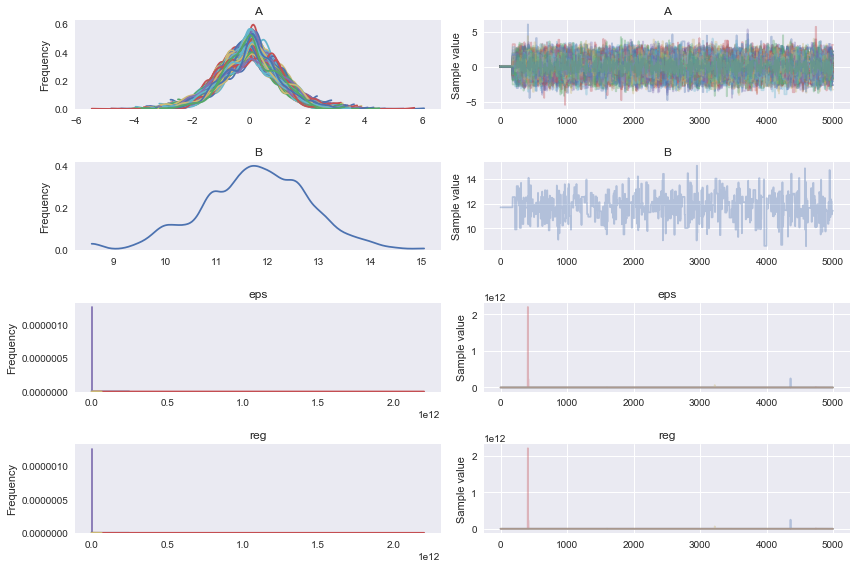

In [22]:
pm.traceplot(trace)